# Recap of what we have done so far

# 1. We recreated Fig A1 from Ore's paper.

We have been working on understanding how to adapt the homologous outflow equations used in Ore's paper (https://arxiv.org/pdf/1904.07244.pdf) to MCRaT. 

Our first step is to understand how these equations work. We do so by replicating Figure A1 in the paper. 

Once we figured out our units with Ore's help, we were able to replicate the plots.

These are the steps we take to get there:

We first import the necessary libraries.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as unit
import astropy.constants as const
from matplotlib.patches import Rectangle
%matplotlib notebook

We now define a 2D spherical outflow function, which returns a grid with the appropiate values for energy density 
(erg cm$^{-3}$), $\Gamma$ (unitless) and density (g cm$^{-3}$) for a radial grid.

In [2]:
def make_spherical_outflow( x, y, luminosity, gamma_infinity, r_0):
    r = np.sqrt(x**2+y**2)
    gg=np.zeros(r.shape)
    pp=np.zeros(r.shape)
    
    jj = np.where(r < (r_0 * gamma_infinity))
    kk = np.where(r >= (r_0 * gamma_infinity))

    if len(jj) > 0: 
        gg[jj] = r[jj] / r_0
    gg[kk] = gamma_infinity

    dd = (luminosity / 4 / np.pi / r ** 2 / const.c.cgs.value ** 3 / 
      gg / gamma_infinity)

    if jj[0].size > 0:
        pp[jj] = luminosity / 12 / np.pi / const.c.cgs.value * r_0 ** 2 / r[jj] ** 4
    pp[kk] = (luminosity / 12. / np.pi / const.c.cgs.value * 
      r_0 ** (2. / 3.) / gamma_infinity ** (4. / 3.) * (
      r[kk] ** ( -8. / 3.) ) )
    ee = 3 * pp
    return ee, gg, dd

Define homologous outflow diff. eq's and RK4 solver said diff. eq's. The solver returns solution vectors for values described in its docstring.

In [3]:
def dedr(e,gamma,n,r):
    return  -(8*(e**(3/4))*(4*e + 3*n))/(r*((9*n/(e**(1/4)) + 8*(e**(3/4))))) 

def dgammadr(e,gamma,n,r):
    return (8*(e**(3/4))*gamma)/(r*((9*n/(e**(1/4)) + 8*(e**(3/4)))))

def dndr(e,gamma,n,r):
    return -(6*n*(4*e + 3*n))/(e**(1/4)*r*((9*n/(e**(1/4)) + 8*(e**(3/4)))))

def homologous_outflow( gam, dens, r0, rf, ener = None, h_i = None):
    '''
    Return the solution to ODE soln. vectors (r, energy, gamma, density) 
    from r0 to rf.
    Integrates set of homologous outflow equations with initial conditions 
    
    ener (erg cm^-3 c^-2 = g cm^-3 energy density over c^2), 
    
    gam (unitless Lorentz factor), 
    
    n (g cm^-3 mass density),
    
    from r0 to rf (cm).
    
    INPUT: 
    
    --gam (float): initial Lorentz Factor
    
    --dens (float): initial mass density
    
    --r0 (float): initial radius
    
    --rf (float): final radius
    
    --ener (float): initial energy/$c^2$, default = None
    
    --h_i (float): initial specific enthalpy, default = None
    
    OUTPUT: 
    
    --r_step (numpy array): vector containing radius discretization for solution vectors
    
    --e_arr (numpy array): vector containing solution for energy/$c^2$ as a function of radius
    
    --gamma_arr (numpy array): vector containing solution for Lorentz factor as a function of radius
    
    --n_arr (numpy array): vector containing solution for mass density as a function of radius
    
    --h_arr (numpy array): vector containing solution for specific enthalpy as a function of radius
    
    NOTES:
    
    --Even though the parameter defaults for ener and h_i are None, the function needs one or the other
    in order to retrieve the solution vectors. if ener is given, it will take it as ICs. If h_i is given,
    the function calculates energy from this and proceeds to solve the ODEs with this calculated IC.
    '''
    
    if ener == None:    
        ener = 3*(h_i-1)*dens/4 

    
    e_start = ener #e_tilde #e/const.c.cgs.value**2
    gamma_start = gam
    n_start = dens #/const.m_p.cgs.value

    
    r_step = 10**np.arange(np.log10(r0),np.log10(rf),1e-3)

    
    e_arr = np.zeros(len(r_step))       # create an array of zeros for e
    gamma_arr = np.zeros(len(r_step))   # create an array of zeros for gamma
    n_arr = np.zeros(len(r_step))       # create an array of zeros for n
    e_arr[0] = e_start                  # add initial value of e to array
    gamma_arr[0] = gamma_start          # add initial value of gamma to array
    n_arr[0] = n_start                  # add initial value of n to array

    for i in range (1, len(r_step)):  
        e = e_arr[i-1]
        gamma = gamma_arr[i-1]
        n = n_arr[i-1]
        r = r_step[i-1]
        Dr = r_step[i] - r_step[i-1]

        #calculate k1 for e, gamma and n
        k1_e = dedr(e,gamma,n,r)
        k1_gamma = dgammadr(e,gamma,n,r)
        k1_n = dndr(e,gamma,n,r)

        #calculate k2 for e, gamma and n
        k2_e = dedr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)
        k2_gamma = dgammadr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)
        k2_n = dndr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)

        #calculate k3 for e, gamma and n
        k3_e = dedr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)
        k3_gamma = dgammadr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)
        k3_n = dndr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)

        #calculate k4 for e, gamma and n
        k4_e = dedr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)
        k4_gamma = dgammadr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)
        k4_n = dndr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)

        e_arr[i] = e + (1/6)*Dr*(k1_e+2*k2_e+2*k3_e+k4_e)                   # calc. e at next radius step,add to array
        gamma_arr[i] = gamma + (1/6)*Dr*(k1_gamma+2*k2_gamma+2*k3_gamma+k4_gamma) # calc. gamma at next radius step,add to array
        n_arr[i] = n + (1/6)*Dr*(k1_n+2*k2_n+2*k3_n+k4_n)           # calc. n at next radius tep,add to array
        
    h_arr = 1+ (4*e_arr)/(3*n_arr)
    
    return (r_step, e_arr, gamma_arr, n_arr, h_arr)

We now create a radial grid which we will then populate with spherical outflow properties. 

<IPython.core.display.Javascript object>


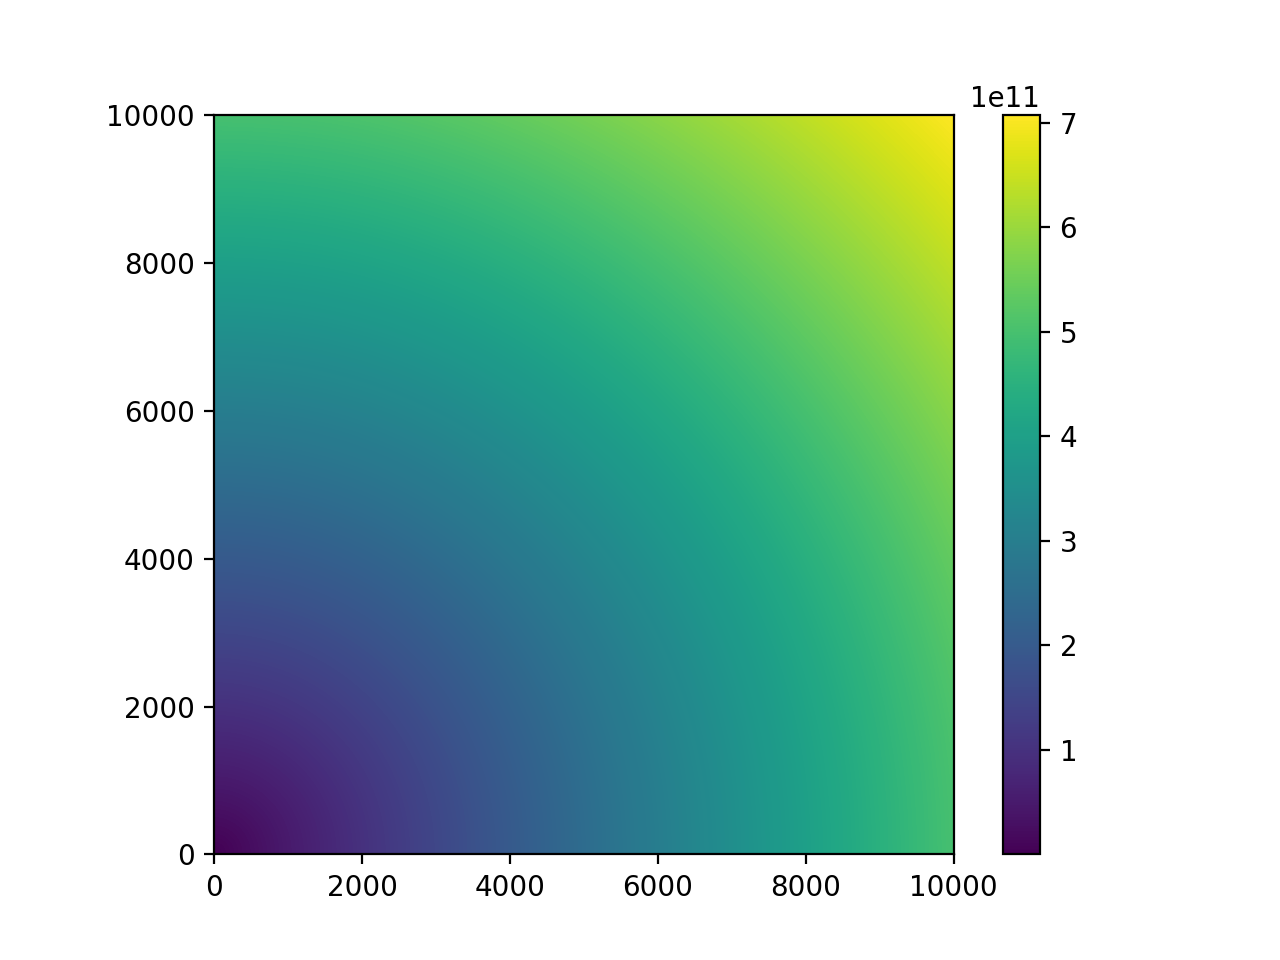

In [4]:
nx_test, ny_test = (10001, 10001) #number of steps
x_test = np.linspace(9e6, 5e11, nx_test) #create x-interval
y_test = np.linspace(9e6, 5e11, ny_test) #create y-interval
xv_test, yv_test = np.meshgrid(x_test, y_test) #create 2D grid with x and y values

r0_test = np.sqrt(xv_test**2+yv_test**2)

plt.imshow(r0_test, origin = 'lower')
plt.colorbar()

We now populate the grid with spherical outflow properties. We set our parameters to be $L_{iso} = 10^{54}$ erg s$^{-1}$, $\Gamma_{\infty}=100$, $r_0 = 10^{8}$ cm.

In [5]:
energy, gamma, density = make_spherical_outflow(xv_test, yv_test, 1e54, 100, 1e8)

energy = energy/const.c.cgs.value**2

h_i = 1+ (4*energy)/(3*density)

We now find points in our grid such that $h_i = 1.1$, $2$, $10$, $100$, $1000$. We will use the HD spherical outflow properties at these indices as initial conditions for the homologous outflow solver.

In [6]:
idx_1_1 = np.unravel_index(np.argmin(np.abs(h_i - 1.1), axis=None), h_i.shape)

idx_2 = np.unravel_index(np.argmin(np.abs(h_i - 2), axis=None), h_i.shape)

idx_10 = np.unravel_index(np.argmin(np.abs(h_i - 10), axis=None), h_i.shape)

idx_100 = np.unravel_index(np.argmin(np.abs(h_i - 100), axis=None), h_i.shape)

idx_1000 = np.unravel_index(np.argmin(np.abs(h_i - 1000), axis=None), h_i.shape)

print("h_i = ", h_i[idx_1_1],h_i[idx_2],h_i[idx_10],h_i[idx_100],h_i[idx_1000])

h_i =  1.0999999998897223 2.000001690122684 9.998163216054088 108.57761312651107 1048.5656017578478


We now plug these values into our homologous outflow solver.

In [7]:
r_1_1, e_arr_1_1, gamma_arr_1_1, n_arr_1_1, h_arr_1_1 = homologous_outflow(
    gamma[idx_1_1], density[idx_1_1], 
    r0_test[idx_1_1], r0_test[idx_1_1]*1e5, h_i = h_i[idx_1_1])

r_2, e_arr_2, gamma_arr_2, n_arr_2, h_arr_2 = homologous_outflow(
    gamma[idx_2], density[idx_2], 
    r0_test[idx_2], r0_test[idx_2]*1e5, h_i = h_i[idx_2])

r_10, e_arr_10, gamma_arr_10, n_arr_10, h_arr_10 = homologous_outflow(
    gamma[idx_10], density[idx_10]*1e5, 
    r0_test[idx_10], r0_test[idx_10]*1e5, h_i = h_i[idx_10])

r_100, e_arr_100, gamma_arr_100, n_arr_100, h_arr_100 = homologous_outflow(
    gamma[idx_100], density[idx_100], 
    r0_test[idx_100], r0_test[idx_100]*1e5, h_i = h_i[idx_100])

r_1000, e_arr_1000, gamma_arr_1000, n_arr_1000, h_arr_1000 = homologous_outflow(
    gamma[idx_1000], density[idx_1000], 
    r0_test[idx_1000], r0_test[idx_1000]*1e5, h_i = h_i[idx_1000])

With these solutions, we now can replicate Figure A1 from Ore's paper. The plot is shown below.

<IPython.core.display.Javascript object>


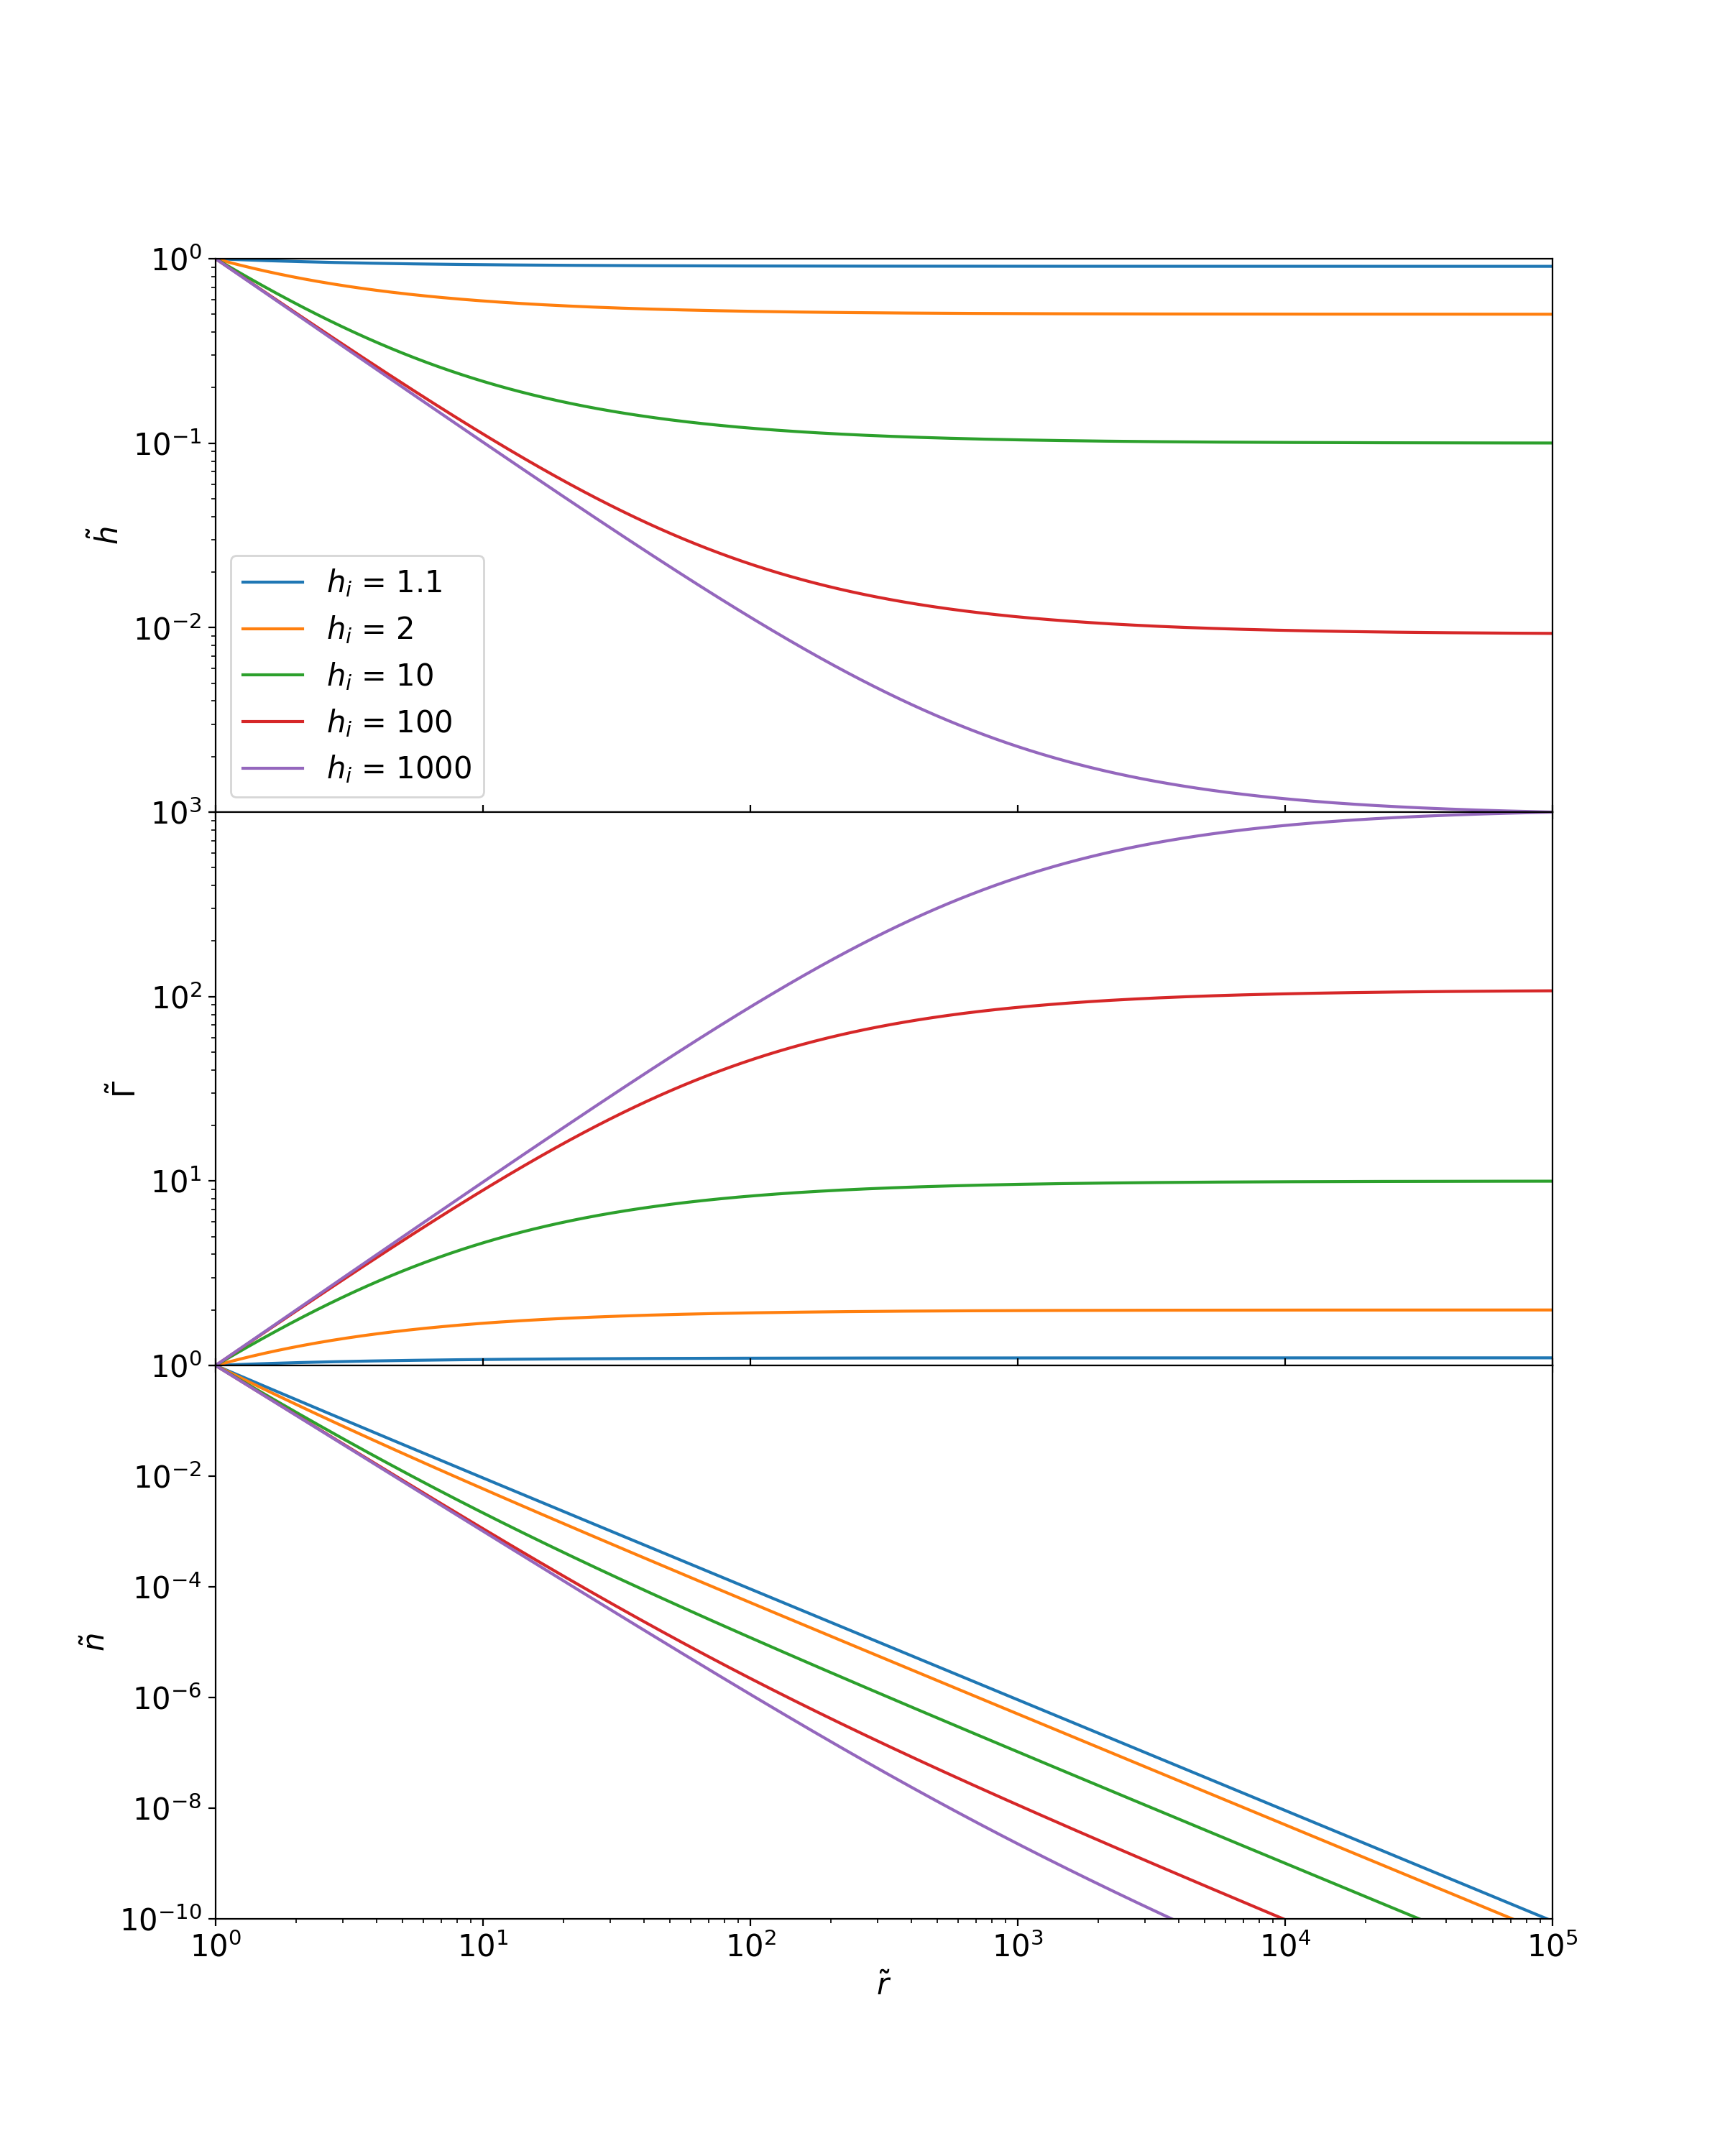

In [8]:
plt.rcParams.update({'font.size': 15})

f, axarr = plt.subplots(3, sharex=True)

f.set_figwidth(12)
f.set_figheight(15)

axarr[0].loglog(r_1_1/r_1_1[0], h_arr_1_1/h_arr_1_1[0], label = '$h_i$ = 1.1')
axarr[0].loglog(r_2/r_2[0], h_arr_2/h_arr_2[0], label = '$h_i$ = 2')
axarr[0].loglog(r_10/r_10[0], h_arr_10/h_arr_10[0], label = '$h_i$ = 10')
axarr[0].loglog(r_100/r_100[0], h_arr_100/h_arr_100[0], label = '$h_i$ = 100')
axarr[0].loglog(r_1000/r_1000[0], h_arr_1000/h_arr_1000[0], label = '$h_i$ = 1000')

axarr[0].set_ylim(1e-3,1e0)

axarr[0].legend()

axarr[1].loglog(r_1_1/r_1_1[0], gamma_arr_1_1/gamma_arr_1_1[0])
axarr[1].loglog(r_2/r_2[0], gamma_arr_2/gamma_arr_2[0])
axarr[1].loglog(r_10/r_10[0], gamma_arr_10/gamma_arr_10[0])
axarr[1].loglog(r_100/r_100[0], gamma_arr_100/gamma_arr_100[0])
axarr[1].loglog(r_1000/r_1000[0], gamma_arr_1000/gamma_arr_1000[0])

axarr[1].set_ylim(1e0,1e3)



axarr[2].loglog(r_1_1/r_1_1[0], n_arr_1_1/n_arr_1_1[0])
axarr[2].loglog(r_2/r_2[0], n_arr_2/n_arr_2[0])
axarr[2].loglog(r_10/r_10[0], n_arr_10/n_arr_10[0])
axarr[2].loglog(r_100/r_100[0], n_arr_100/n_arr_100[0])
axarr[2].loglog(r_1000/r_1000[0], n_arr_1000/n_arr_1000[0])

axarr[2].set_xlim(1e0,1e5)

axarr[2].set_ylim(1e-10,1e0)

yticks0 = axarr[0].yaxis.get_major_ticks()
    
yticks0[1].label1.set_visible(False)

yticks1 = axarr[1].yaxis.get_major_ticks()
    
yticks1[1].label1.set_visible(False)

axarr[0].tick_params(axis="x", bottom=True, top=False, labelbottom=False, labeltop=False)

axarr[1].tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=False)

axarr[2].tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=False)

axarr[0].set_ylabel('$\~{h}$')

axarr[1].set_ylabel('$\~{\Gamma}$')

axarr[2].set_ylabel('$\~{n}$')

axarr[2].set_xlabel('$\~{r}$')

plt.subplots_adjust(hspace=.0)



# 2. We now focus on understanding how cells propagate as time progresses.

Now that we understand how to properly use these homologous outflow equations, the fun begins. We consider a cell grid containing spherical outflow properties. We wish to have this grid evolve in time, as it moves at velocity $c$ as shown in eq'n. 5 in Sec. 3.2 in Ore's paper.

In [9]:
def omega(v):
    '''
    Return $\hat{\Omega} = \dot{r}/|\dot{r}|$ in 2D. 
    This quantity is the unit first time derivative of the radius vector.
    
    INPUT: 
    
    --v (numpy array): 2D vector containing x,y components of 
    velocity vector.
    
    OUTPUT: 
    
    --omega (numpy array): 2D vector containing x,y components of 
    velocity unit vector.
    '''
    v_hat = v/np.linalg.norm(v)
    
    return v_hat

def s(t_sim, t):
    '''
    Return $s = c (t-t_{sim})$ in 2D. 
    This quantity is the step size the cell takes when moving at 
    speed $c$ from time $t_{sim}$ to time $t$. 
    
    INPUT: 
    
    --t_sim (float): initial time
    
    --t (float): final time
    
    --v (float): speed
    
    OUTPUT: 
    
    --s float: magnitude of step taken in time $(t-t_{sim}})$ given by velocity $c$ or $v$.
    '''

    s = (t-t_sim)*const.c.cgs.value
    
    return s

def r_step_c(r_i,s,omega_hat):
    '''
    Return $r = r_i + s \hat{\Omega}$ in 2D. 
    This quantity is the step size the cell takes when moving a distance
    given by s from time $t_{sim}$ to time $t$
    
    INPUT: 
    
    --r_i (numpy array)
    
    --t_sim (float): initial time
    
    --t (float): final time
    
    OUTPUT: 
    
    --s float: magnitude of step taken in time $(t-t_{sim}})$
    '''
    r = r_i + s*omega_hat
    
    return r

In a spherical outflow, $\hat{\Omega}\equiv \hat{v} = \frac{\dot{\vec{r}}}{|\dot{\vec{r}}|}=\frac{\vec{r}}{|\vec{r}|}$. 

Unit radius vector is the same as the velocity unit vector.

Using a spherical outflow as the guidelines for each cell's expansion trajectory leads to an issue. We now have cells that are scattering radially. Since there are not infinitely many cells, as time progresses, these cells grow further apart. 

To see how much these grow apart, we consider a 100X100 cell grid whose cells are all the same sized squares.

We will test this for a cell grid that's located along the y-axis (jet axis). Since we will adapt this to an HD frame later, we need the border of the cell column closest to the axis to be at x = 0 instead of the cell coordinate itself, so there is no part of the cell in the negative x-axis. 

We want the cell size to be $10^9$ cm at a radius of $\sim10^{12}$ cm, to better replicate the AMR grid that we would encounter at the end of an HD GRB simulation, where we expect to have reached a homologous outflow.

In [10]:
cell_size = 1e9

nx_jet_axis, ny_jet_axis = (101, 101) #number of steps
x_jet_axis = np.linspace(cell_size/2, cell_size/2 + 0.1e12, nx_jet_axis) #create x-interval of size 1e11
y_jet_axis = np.linspace(1e12, 1.1e12, ny_jet_axis) #create y-interval of size 1e11
xv_jet_axis, yv_jet_axis = np.meshgrid(x_jet_axis, y_jet_axis) #create 2D grid with x and y values

r0_jet_axis = np.sqrt(xv_jet_axis**2 + yv_jet_axis**2)

<IPython.core.display.Javascript object>


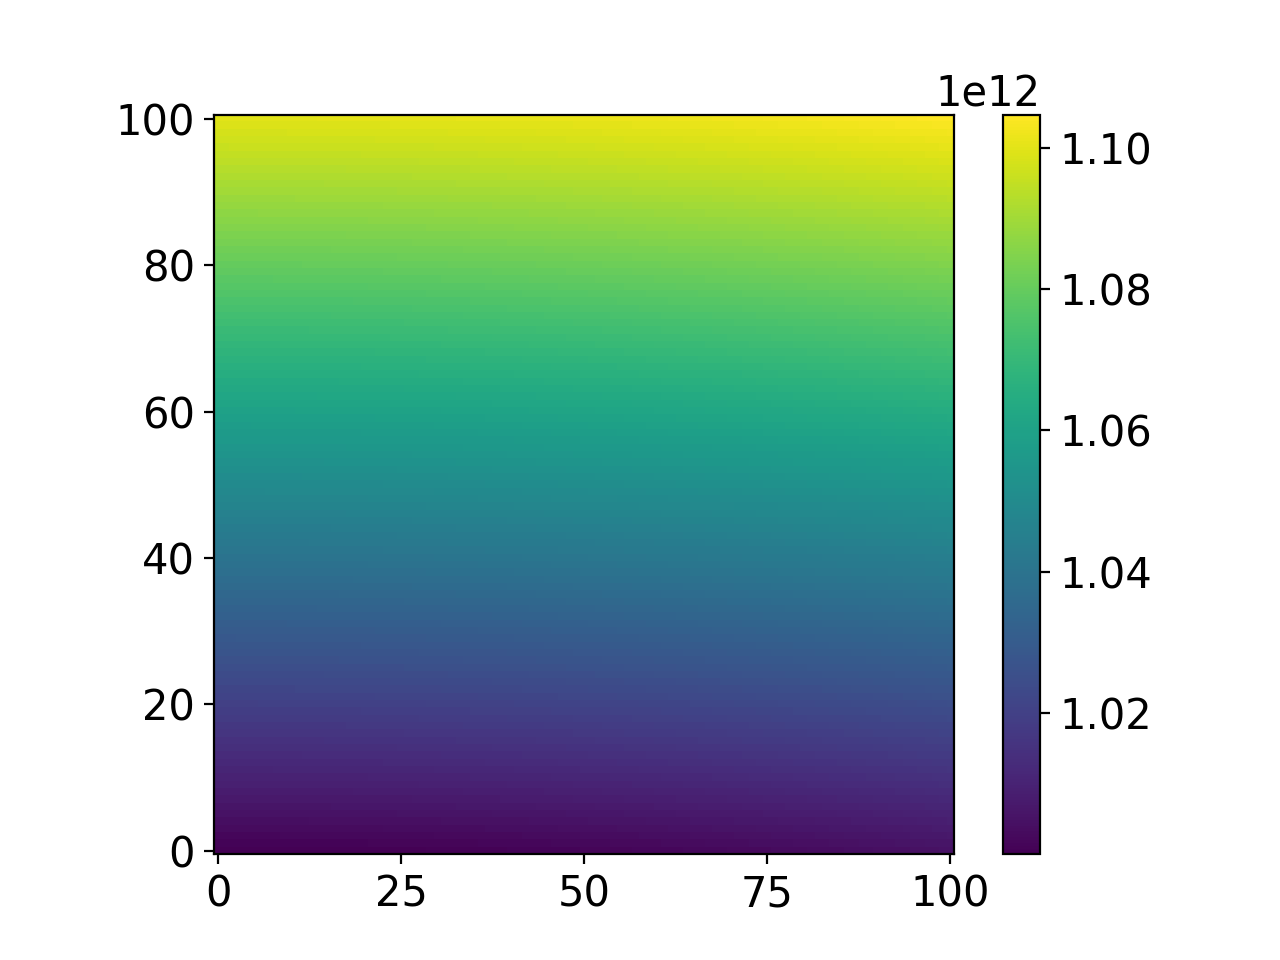

In [11]:
plt.imshow(r0_jet_axis, origin = 'lower')
plt.colorbar()

This is how the cells are spread out in this domain.

<IPython.core.display.Javascript object>


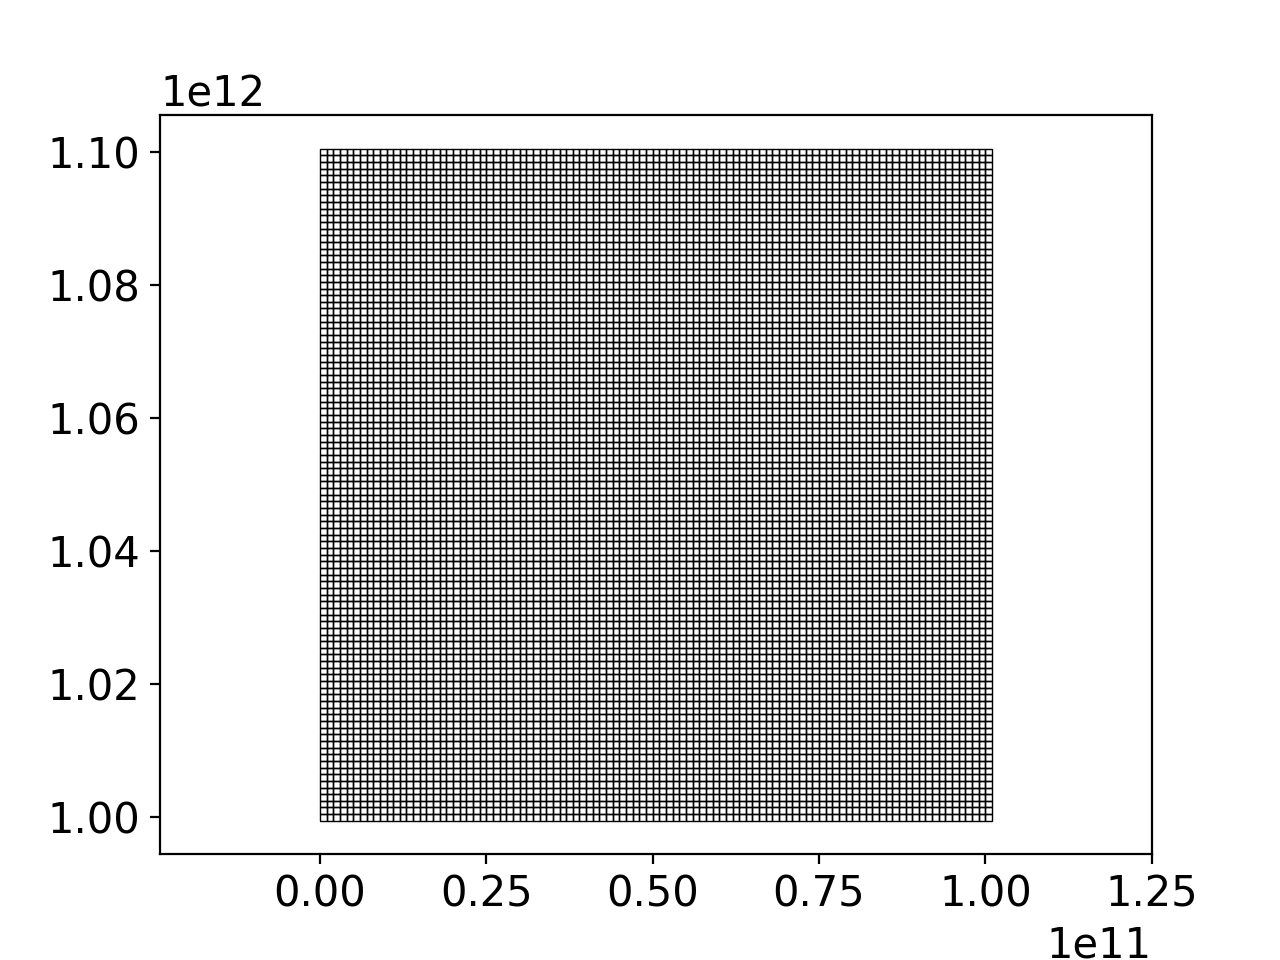

In [12]:
fig = plt.figure()

ax = plt.gca()

#ax.plot(xv_jet_axis, yv_jet_axis, marker='o', color='k', linestyle='none')

jet_axis_cell_size = 1e9

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle(
          (xv_jet_axis[i][j]-jet_axis_cell_size/2, 
          yv_jet_axis[i][j]-jet_axis_cell_size/2), 
          jet_axis_cell_size,jet_axis_cell_size, 
          facecolor="none", ec='k', lw=0.5))
        
plt.axis('equal')

plt.show()

Now let's scatter these cells using the mentioned approximation. To do so, we first populate this grid with spherical outflow properties. We then scatter them for 10, 100, 200, 500 and 1000 seconds.

In [13]:
energy_jet_axis, gamma_jet_axis, density_jet_axis = make_spherical_outflow(
  xv_jet_axis, yv_jet_axis, 1e54, 100, 1e11)

energy_jet_axis = energy_jet_axis/const.c.cgs.value**2

h_i_jet_axis = 1+ (4*energy_jet_axis)/(3*density_jet_axis)

In [14]:
delta_t = [ 20 , 110 , 210 , 510 , 1010 ]

new_radius_jet_axis_c = []

theta_grid = np.arctan(xv_jet_axis/yv_jet_axis)

x_comps_jet_axis_c = []

y_comps_jet_axis_c = []


for t in range(len(delta_t)):
    
    empty_x = np.zeros(xv_jet_axis.shape)
    
    empty_y = np.zeros(yv_jet_axis.shape)
    
    empty_r = np.zeros(r0_jet_axis.shape)
    
    for i in range(len(r0_jet_axis)):

        for j in range(len(r0_jet_axis[i])):

            gamma = gamma_jet_axis[i][j]

            density = density_jet_axis[i][j]

            r_0 = r0_jet_axis[i][j]

            s_t = s(10,delta_t[t])

            omega_hat = omega(np.asarray([
              xv_jet_axis[i][j],yv_jet_axis[i][j]]))

            r_step = r_step_c(np.array([xv_jet_axis[i][j], 
              yv_jet_axis[i][j]]), s_t, omega_hat)

            r_f = np.linalg.norm(r_step)

            empty_x[i,j] = r_f*np.sin(theta_grid[i][j])

            empty_y[i,j] = r_f*np.cos(theta_grid[i][j])

            empty_r[i,j] = r_f
            
    x_comps_jet_axis_c.append(empty_x)
    
    y_comps_jet_axis_c.append(empty_y)
    
    new_radius_jet_axis_c.append(empty_r)

<IPython.core.display.Javascript object>


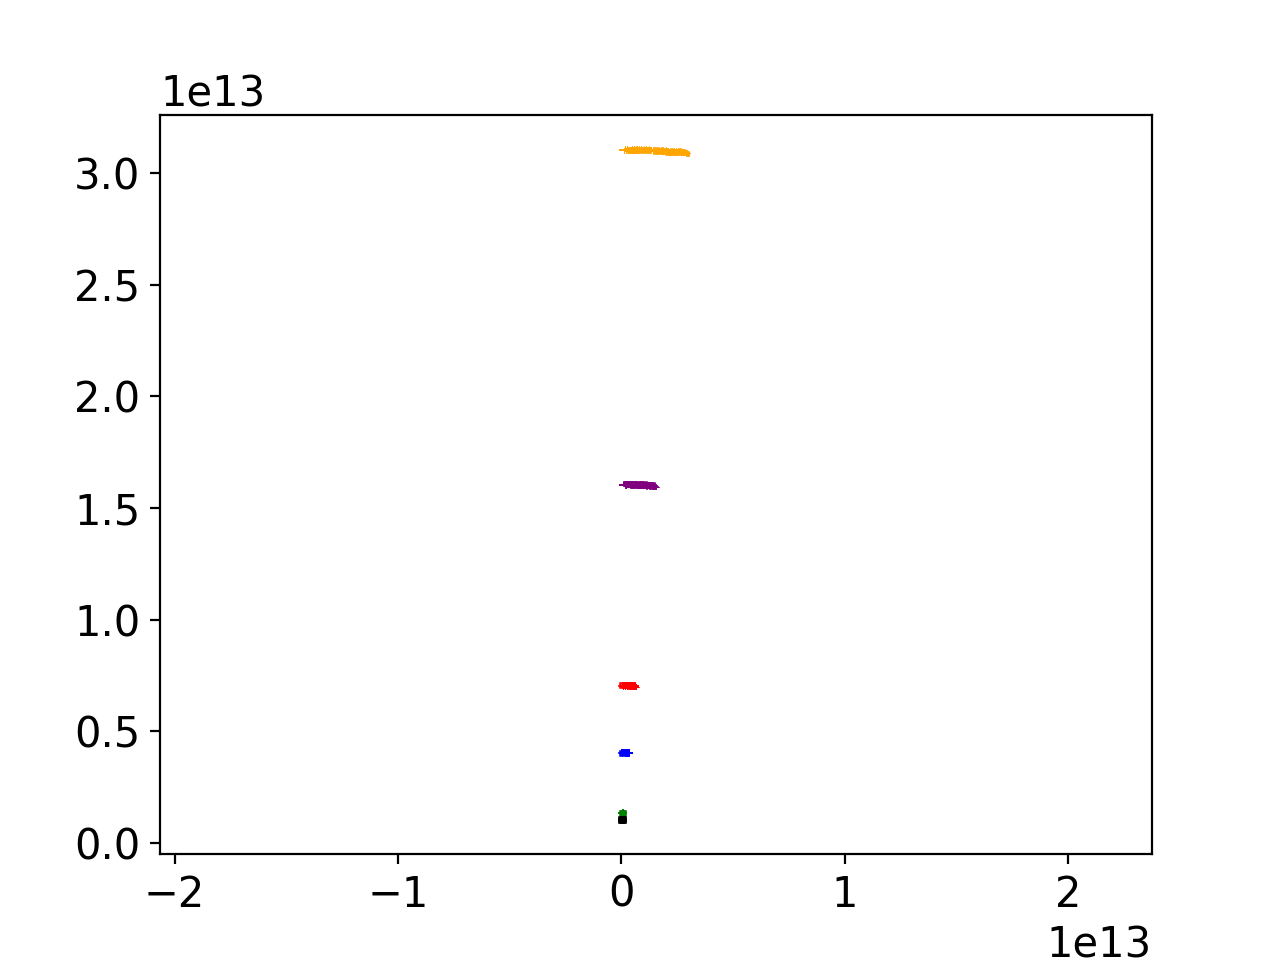

In [15]:
fig = plt.figure()

ax = plt.gca()

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle((xv_jet_axis[i][j]-jet_axis_cell_size/2, 
          yv_jet_axis[i][j]-jet_axis_cell_size/2), jet_axis_cell_size,
          jet_axis_cell_size, facecolor="none", ec='k', lw=2))
        
        ax.add_patch(Rectangle((x_comps_jet_axis_c[0][i][j]-jet_axis_cell_size/2, 
          y_comps_jet_axis_c[0][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,
          jet_axis_cell_size, facecolor="none", ec='green', lw=2))

        ax.add_patch(Rectangle((x_comps_jet_axis_c[1][i][j]-jet_axis_cell_size/2, 
          y_comps_jet_axis_c[1][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,
          jet_axis_cell_size, facecolor="none", ec='blue', lw=2))

        ax.add_patch(Rectangle((x_comps_jet_axis_c[2][i][j]-jet_axis_cell_size/2, 
          y_comps_jet_axis_c[2][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,
          jet_axis_cell_size, facecolor="none", ec='red', lw=2))

        ax.add_patch(Rectangle((x_comps_jet_axis_c[3][i][j]-jet_axis_cell_size/2, 
          y_comps_jet_axis_c[3][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,
          jet_axis_cell_size, facecolor="none", ec='purple', lw=2))

        ax.add_patch(Rectangle((x_comps_jet_axis_c[4][i][j]-jet_axis_cell_size/2, 
          y_comps_jet_axis_c[4][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,
          jet_axis_cell_size, facecolor="none", ec='orange', lw=2))


plt.axis('equal')

plt.show()

As time progresses, the cell angle bins have a larger arc length. Once the arc length of the angle bin becomes larger than the arc length of the cells, there is spacing between subsequent cells. 

For any two subsequent cells with cell size $l$ near any axis, this happens at a radius $r\sim \frac{2l}{\Delta \theta}$, where $\Delta \theta = \theta_2-\theta_1$ for any two subsequent angle bins. 

For any two subsequent cells near $45^\circ$, this happens at radius $r\sim \frac{2\sqrt{2} \cdot l}{\Delta \theta}$.

Therofore, this happens at around $4-6\times 10^{12}$ cm for the cell grid we have been using, which translates to about 100-170 s.

<IPython.core.display.Javascript object>


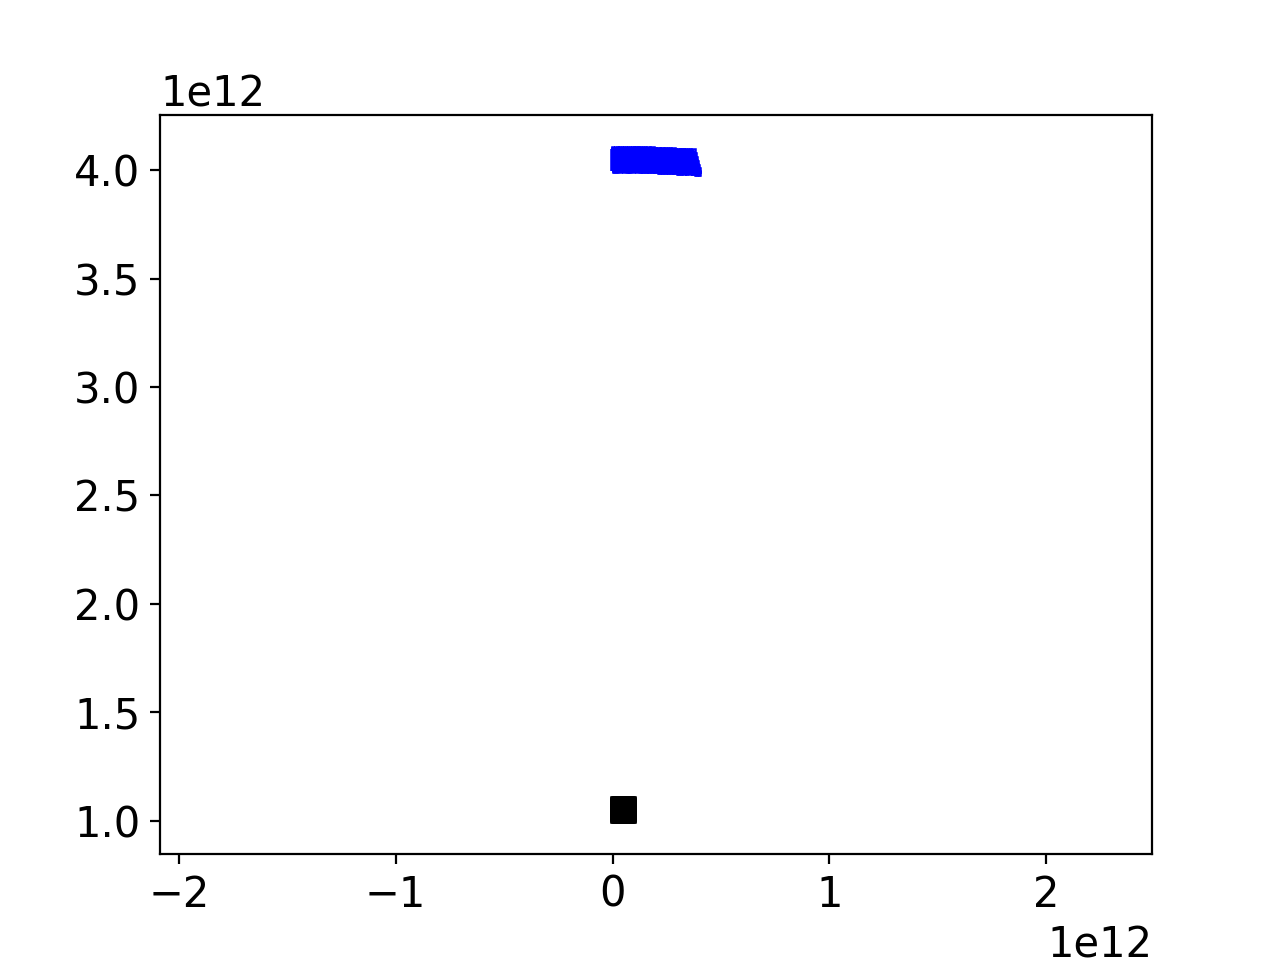

In [16]:
fig = plt.figure()

ax = plt.gca()

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle((xv_jet_axis[i][j]-jet_axis_cell_size/2, yv_jet_axis[i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='k', lw=2))
        
#         ax.add_patch(Rectangle((x_comps_jet_axis_c[0][i][j]-jet_axis_cell_size/2, y_comps_jet_axis_c[0][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='green', lw=2))

        ax.add_patch(Rectangle((x_comps_jet_axis_c[1][i][j]-jet_axis_cell_size/2, y_comps_jet_axis_c[1][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='blue', lw=2))

#         ax.add_patch(Rectangle((x_comps_jet_axis_c[2][i][j]-jet_axis_cell_size/2, y_comps_jet_axis_c[2][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='red', lw=2))

#         ax.add_patch(Rectangle((x_comps_jet_axis_c[3][i][j]-jet_axis_cell_size/2, y_comps_jet_axis_c[3][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='purple', lw=2))

#         ax.add_patch(Rectangle((x_comps_jet_axis_c[4][i][j]-jet_axis_cell_size/2, y_comps_jet_axis_c[4][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='orange', lw=2))


plt.axis('equal')

plt.show()

<IPython.core.display.Javascript object>


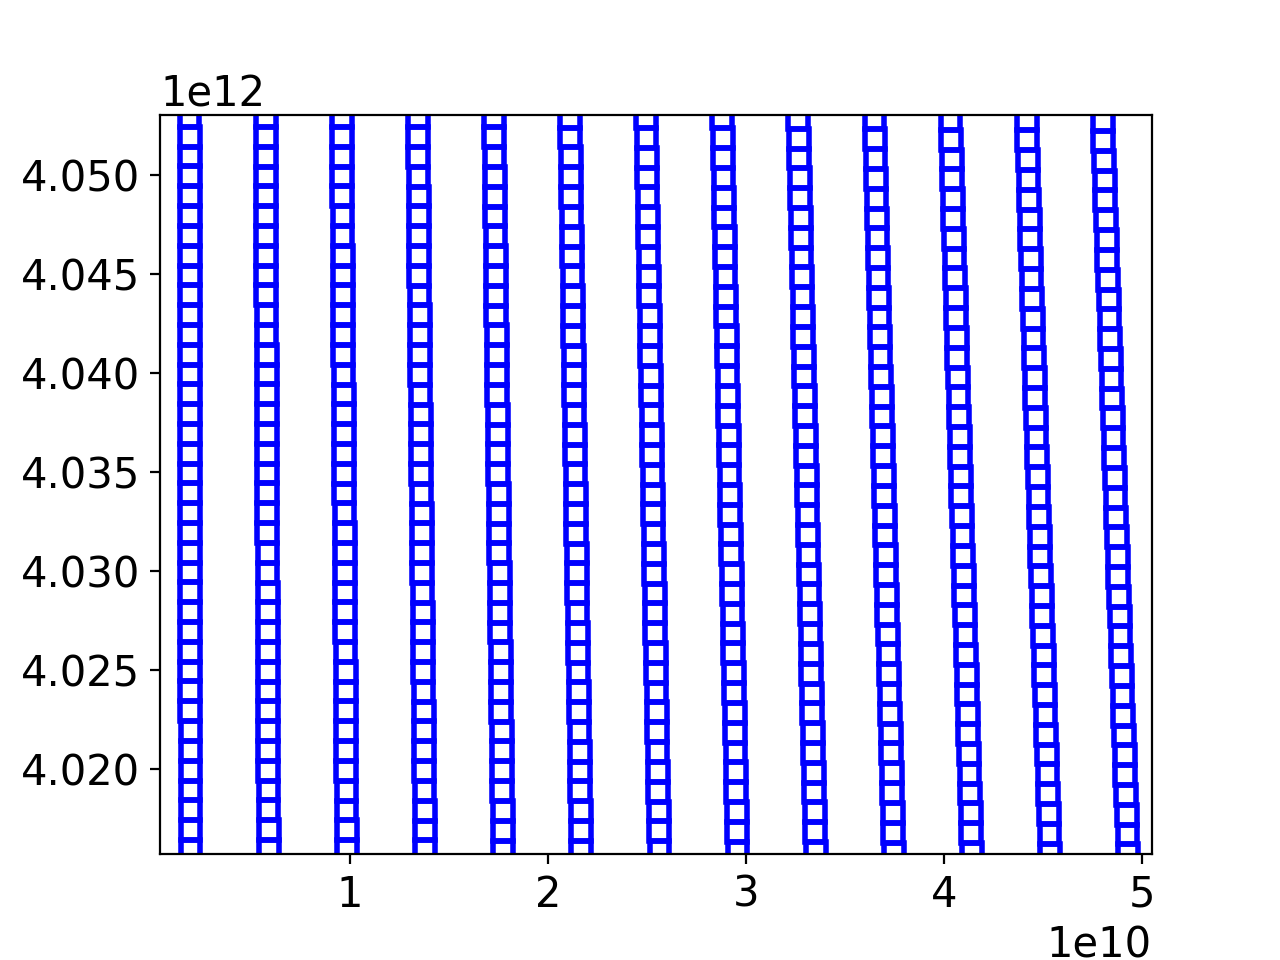

In [17]:
fig = plt.figure()

ax = plt.gca()

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle((xv_jet_axis[i][j]-jet_axis_cell_size/2, yv_jet_axis[i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='k', lw=2))
        
#         ax.add_patch(Rectangle((x_comps_jet_axis_c[0][i][j]-jet_axis_cell_size/2, y_comps_jet_axis_c[0][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='green', lw=2))

        ax.add_patch(Rectangle((x_comps_jet_axis_c[1][i][j]-jet_axis_cell_size/2, y_comps_jet_axis_c[1][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='blue', lw=2))

#         ax.add_patch(Rectangle((x_comps_jet_axis_c[2][i][j]-jet_axis_cell_size/2, y_comps_jet_axis_c[2][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='red', lw=2))

#         ax.add_patch(Rectangle((x_comps_jet_axis_c[3][i][j]-jet_axis_cell_size/2, y_comps_jet_axis_c[3][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='purple', lw=2))

#         ax.add_patch(Rectangle((x_comps_jet_axis_c[4][i][j]-jet_axis_cell_size/2, y_comps_jet_axis_c[4][i][j]-jet_axis_cell_size/2), jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='orange', lw=2))


plt.axis('equal')

plt.show()

# 3. We now focus on understanding how the HD properties of the cell grid change using this method.

We can populate the original cell grid with spherical outflow properties and let it scatter and evolve in time according to the homologous outflow equations. 

In [18]:
g_moved = []

e_moved = []

n_moved = []

h_moved = []

for t in range(len(delta_t)):
    
    gam = np.zeros(gamma_jet_axis.shape)
    
    ener = np.zeros(energy_jet_axis.shape)
    
    dens = np.zeros(density_jet_axis.shape)
    
    h = np.zeros(h_i_jet_axis.shape)
    
    for i in range(len(r0_jet_axis)):
        
        for j in range(len(r0_jet_axis[i])):
        
            r, e, g, n, enth = homologous_outflow(
              gamma_jet_axis[i,j], 
              density_jet_axis[i,j], 
              r0_jet_axis[i,j], 
              new_radius_jet_axis_c[t][i,j], 
              h_i = h_i_jet_axis[i,j])
            
            ener[i,j] = e[-1]
            
            gam[i,j] = g[-1]
            
            dens[i,j] = n[-1]
            
            h[i,j] = enth[-1]
            
            #print(i,j)
            
    #print(t)
            
    g_moved.append(gam)
    
    e_moved.append(ener)
    
    n_moved.append(dens)
    
    h_moved.append(h)

We now plot the properties of the old vs. new frame.

We now plot the initial (spherical outflow) Lorentz factor.

<IPython.core.display.Javascript object>


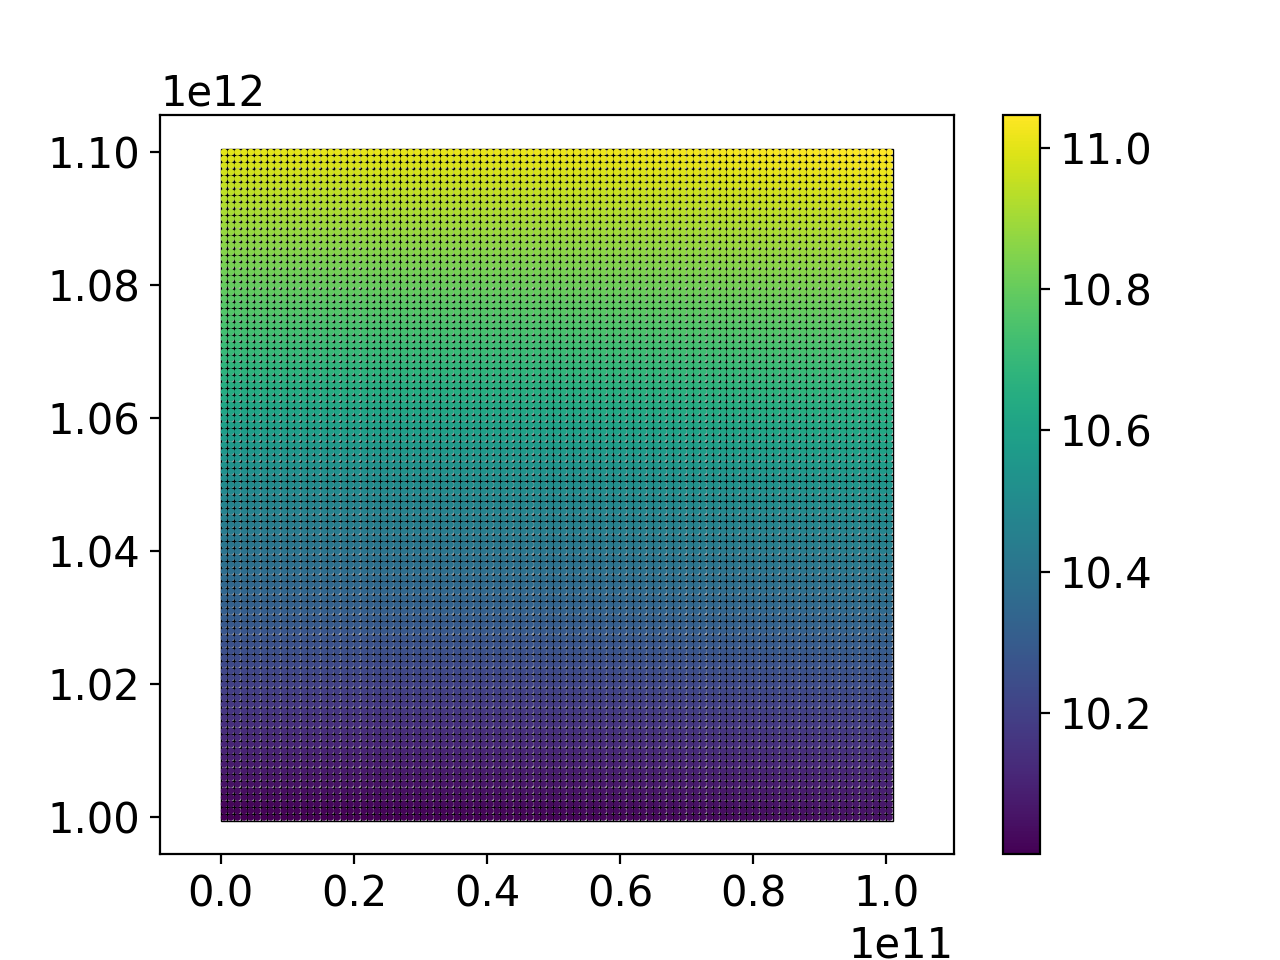

In [19]:
fig = plt.figure()

ax = plt.gca()

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle((xv_jet_axis[i][j]-jet_axis_cell_size/2, 
          yv_jet_axis[i][j]-jet_axis_cell_size/2), jet_axis_cell_size,
          jet_axis_cell_size, facecolor="none", ec='k', lw=0.5))

mapp1 = ax.scatter(xv_jet_axis,yv_jet_axis, c = gamma_jet_axis, s = 2)

cb1 = plt.colorbar(mappable = mapp1, ax = ax)

plt.axis('equal')

plt.show()

We now plot the Lorentz factor after the grid evolved for 100 seconds.

<IPython.core.display.Javascript object>


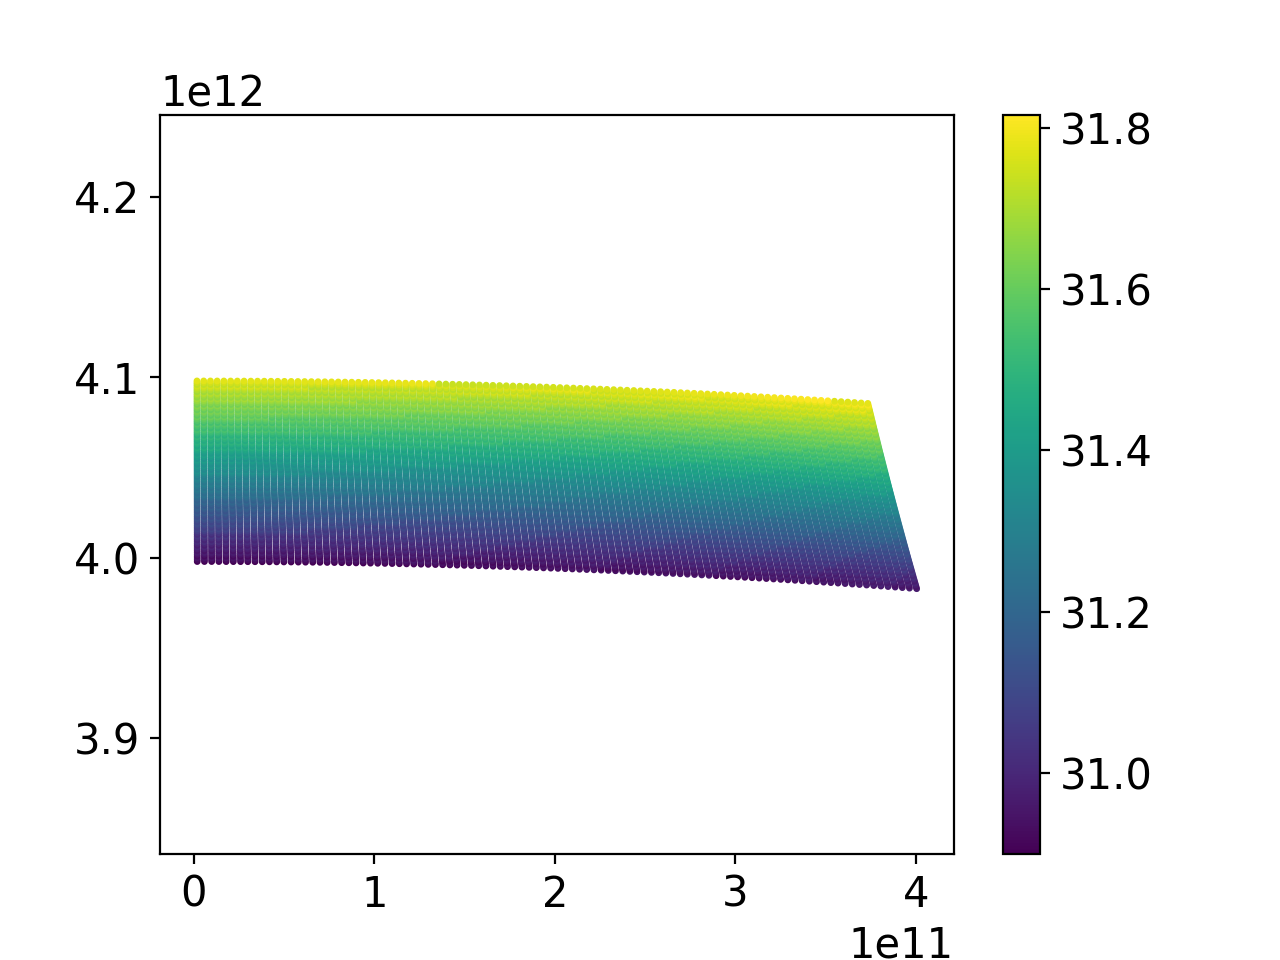

In [20]:
fig = plt.figure()

ax = plt.gca()

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle((x_comps_jet_axis_c[1][i][j]-jet_axis_cell_size/2, 
          y_comps_jet_axis_c[1][i][j]-jet_axis_cell_size/2), 
          jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='k', lw=0.5))

mapp1 = ax.scatter(x_comps_jet_axis_c[1],y_comps_jet_axis_c[1], c = g_moved[1], s = 2)

cb1 = plt.colorbar(mappable = mapp1, ax = ax)

plt.axis('equal')

plt.show()

We now plot the Lorentz factor after the grid evolved for 1000 seconds.

<IPython.core.display.Javascript object>


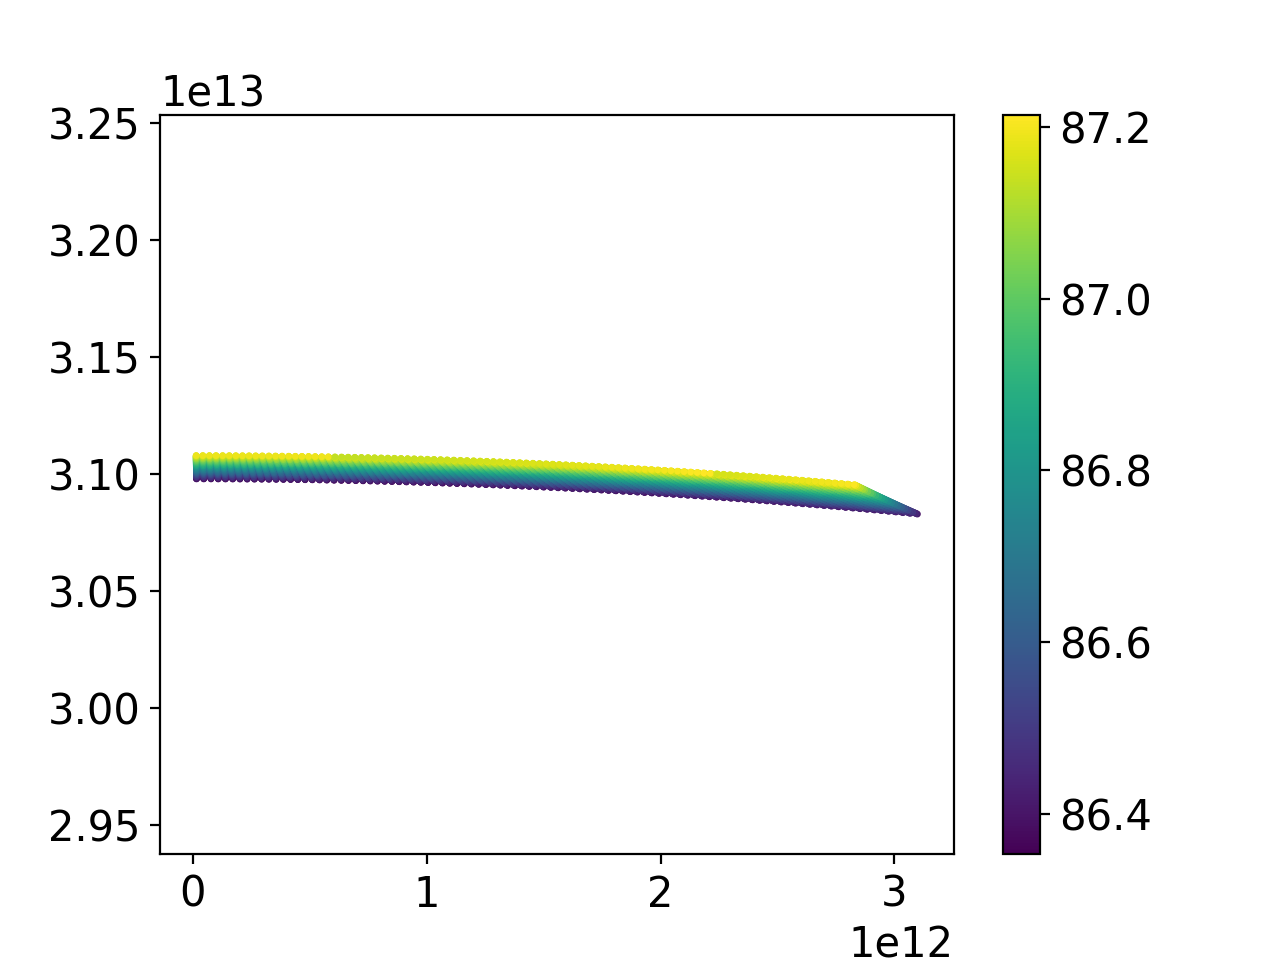

In [21]:
fig = plt.figure()

ax = plt.gca()

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle((x_comps_jet_axis_c[4][i][j]-jet_axis_cell_size/2, 
          y_comps_jet_axis_c[4][i][j]-jet_axis_cell_size/2), 
          jet_axis_cell_size,jet_axis_cell_size, facecolor="none", ec='k', lw=0.5))

mapp1 = ax.scatter(x_comps_jet_axis_c[4],y_comps_jet_axis_c[4], c = g_moved[4], s = 2)

cb1 = plt.colorbar(mappable = mapp1, ax = ax)

plt.axis('equal')

plt.show()

# 4. Our next goal is to understand how to apply this method to an HD frame of a GRB jet.

We are now currently working on understanding how to read in an HD sim. frame (either FLASH or PLUTO) to test this method but on HD properties that aren't that of a spherical outflow. We are using the yt Python Library to earn how to do this.

Our end goal is to understand how the cell grid shape changes as time progresses, such that we are able to interpolate the data to fill in the blanks left by the spacing between cells.